<h1 align="center"> DALLE⁻¹ </h1>

# Abstract

The DALLE⁻¹ project aims to create and train a model that will be able to describe pictures using natural language. We achieved this by reimplementing the model from [Show, attend and tell: Neural image caption generation with visual attention](https://arxiv.org/pdf/1502.03044.pdf) and trained it ourselves. For the training, we used the described images from the [COCO](https://paperswithcode.com/dataset/coco) and [Flickr 8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) database. The accuracy of the description was measured with BLEU meter. Trained models can be found [here](https://drive.google.com/drive/folders/1w4obEyGMoNUO38Q24v1I1d7sADHUuuS2?usp=drive_link).

# Results

Here are our results after successive epochs of training on the Flickr 8k dataset.

<table>
    <tr>
        <td>epoch</td>
        <td></td>
        <td>BLEU-1</td>
        <td>BLEU-2</td>
        <td>BLEU-3</td>
        <td>BLEU-4</td>
    </tr>
    <tr>
        <td>5</td>
        <td>test</td>
        <td>0.636</td>
        <td>0.431</td>
        <td>0.293</td>
        <td>0.200</td>
    </tr>
    <tr>
        <td></td>
        <td>val</td>
        <td>0.624</td>
        <td>0.417</td>
        <td>0.279</td>
        <td>0.186</td>
    </tr>
    <tr>
        <td></td>
        <td>test+val</td>
        <td>0.630</td>
        <td>0.424</td>
        <td>0.286</td>
        <td>0.193</td>
    </tr>
    <tr>
        <td>4</td>
        <td>test</td>
        <td>0.642</td>
        <td>0.435</td>
        <td>0.297</td>
        <td>0.201</td>
    </tr>
    <tr>
        <td></td>
        <td>val</td>
        <td>0.629</td>
        <td>0.423</td>
        <td>0.285</td>
        <td>0.192</td>
    </tr>
    <tr>
        <td></td>
        <td>test+val</td>
        <td>0.636</td>
        <td>0.429</td>
        <td>0.291</td>
        <td>0.197</td>
    </tr>
    <tr>
        <td>3</td>
        <td>test</td>
        <td>0.639</td>
        <td>0.427</td>
        <td>0.292</td>
        <td>0.198</td>
    </tr>
    <tr>
        <td></td>
        <td>val</td>
        <td>0.627</td>
        <td>0.420</td>
        <td>0.289</td>
        <td>0.197</td>
    </tr>
    <tr>
        <td></td>
        <td>test+val</td>
        <td>0.633</td>
        <td>0.424</td>
        <td>0.291</td>
        <td>0.197</td>
    </tr>
    <tr>
        <td>2</td>
        <td>test</td>
        <td>0.628</td>
        <td>0.414</td>
        <td>0.277</td>
        <td>0.186</td>
    </tr>
    <tr>
        <td></td>
        <td>val</td>
        <td>0.629</td>
        <td>0.417</td>
        <td>0.281</td>
        <td>0.187</td>
    </tr>
    <tr>
        <td></td>
        <td>test+val</td>
        <td>0.628</td>
        <td>0.416</td>
        <td>0.279</td>
        <td>0.187</td>
    </tr>
    <tr>
        <td>1</td>
        <td>test</td>
        <td>0.607</td>
        <td>0.385</td>
        <td>0.246</td>
        <td>0.158</td>
    </tr>
    <tr>
        <td></td>
        <td>val</td>
        <td>0.602</td>
        <td>0.381</td>
        <td>0.243</td>
        <td>0.156</td>
    </tr>
    <tr>
        <td></td>
        <td>test+val</td>
        <td>0.605</td>
        <td>0.383</td>
        <td>0.244</td>
        <td>0.157</td>
    </tr>
</table>

In [1]:
import torch
from torch import nn, optim
from torchvision.datasets import CocoCaptions
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchtext.data.metrics import bleu_score
import torchvision.transforms as transforms
import torchvision.models
import numpy as np
import skimage
from tqdm.notebook import tqdm
from PIL import Image
from more_itertools import chunked
from time import time as time
import matplotlib.pyplot as plt
import gc
import json

%matplotlib inline

In [2]:
flickr8k_dataset_path = "flickr8k/Flicker8k_Dataset/"
# flickr8k_annotation_path = "flickr8k/Flickr8k_annotation"
flickr8k_splits_path = "flickr8k/dataset_flickr8k.json"

coco_dataset_path = "coco/train2014"
coco_annotation_path = "coco/annotations/captions_train2014.json"

words_path = "embeddings/words.txt"

## Vocabulary



In [14]:
![ -d embeddings ] || gdown --folder 'https://drive.google.com/drive/folders/1U4EzDL-6Ft60yw2Ng67-SanZpqhIalV4?usp=drive_link' -O embeddings

Retrieving folder list
Processing file 1NFNDj7q-OJioweBNAapBGJmlywFEzntI nowak.jpg
Processing file 1QIYvx7yWbgtphh73tzYORDcYVGD5GNPx words.txt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1NFNDj7q-OJioweBNAapBGJmlywFEzntI
To: /content/embeddings/nowak.jpg
100% 337k/337k [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QIYvx7yWbgtphh73tzYORDcYVGD5GNPx
To: /content/embeddings/words.txt
100% 568k/568k [00:00<00:00, 31.6MB/s]
Download completed


In [7]:
with open(words_path, "r") as f:
    vocab = f.read().split()

# Training datasets

Instead of training the model, you can use the one we trained. See section **Loading a model**.


## COCO

In [ ]:
!pip -q install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"
!mkdir -p coco
![ -e coco/annotations_trainval2014.zip ] || wget -q http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P coco
![ -e coco/train2014.zip ] || wget http://images.cocodataset.org/zips/train2014.zip -P coco
![ -d coco/annotations ] || unzip -q coco/annotations_trainval2014.zip -d coco
![ -d coco/train2014 ] || unzip -q coco/train2014.zip -d coco

  Preparing metadata (setup.py) ... done
--2023-06-16 18:51:40--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.230.121, 3.5.16.171, 52.217.174.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.230.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘coco/train2014.zip’

train2014.zip       100%[===================>]  12.58G  13.4MB/s    in 16m 57s 

2023-06-16 19:08:38 (12.7 MB/s) - ‘coco/train2014.zip’ saved [13510573713/13510573713]



In [ ]:
cap = CocoCaptions(coco_dataset_path, coco_annotation_path,
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))]))

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


In [ ]:
img, target = cap[3] # load 4th sample

ax = subplot(1, 1, 1)
ax.set_xlabel("\n".join(target))

print('Number of samples: ', len(cap))
print("Image Size: ", img.size())
plt.imshow(img.transpose(0,1).transpose(1,2))

Number of samples:  82783
Image Size:  torch.Size([3, 224, 224])


In [ ]:
img, target = cap[400] # load 4th sample

ax = plt.subplot(1, 1, 1)
ax.set_xlabel("\n".join(target))

print('Number of samples: ', len(cap))
print("Image Size: ", img.size())
plt.imshow(img.transpose(0,1).transpose(1,2))
plt.show()

Number of samples:  82783
Image Size:  torch.Size([3, 224, 224])


## Flickr8k

In [ ]:
![ -d flickr8k ] || mkdir flickr8k
![ -d flickr8k/data ] || cd flickr8k && gdown https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O data && unzip -q data
![ -d flickr8k/Flickr8k_annotation ] || cd flickr8k && gdown http://hockenmaier.cs.illinois.edu/8k-pictures.html -O Flickr8k_annotation
![ -d flickr8k/dataset_flickr8k.json ] || cd flickr8k && gdown 14Y336VVWnhvm-eyKqQAUPZSz9-sRLa7L -O dataset_flickr8k.json

Downloading...
From: https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
To: /content/flickr8k/data
100% 1.12G/1.12G [00:17<00:00, 62.0MB/s]
Downloading...
From: http://hockenmaier.cs.illinois.edu/8k-pictures.html
To: /content/flickr8k/Flickr8k_annotation
100% 3.70M/3.70M [00:00<00:00, 7.12MB/s]
Downloading...
From: https://drive.google.com/uc?id=14Y336VVWnhvm-eyKqQAUPZSz9-sRLa7L
To: /content/flickr8k/dataset_flickr8k.json
100% 9.04M/9.04M [00:00<00:00, 98.6MB/s]


In [ ]:
# Mostly from the torch implementation
class Flickr8k(Dataset):
    def __init__(self, root, ann_file, split="train", transform=None):
        super().__init__()
        self.split = split
        self.root  = root
        self.transform = transform
        """ Annotation structure:
            {
                dataset: "flickr8k",
                images: [
                    {
                        imgid: 0
                        split: 'train',
                        filename: '2513260012_03d33305cf.jpg'
                        sentids: [0, 1, 2, 3, 4]
                        sentences: [
                            {
                                tokens: ['a', 'black', 'dog'],
                                raw: 'a black dog.'
                                imgid: 0,
                                sentid: 0
                            }
                            ........
                        ]
                    }
                    ........
                ]}
        """
        f = open(ann_file, "r")
        dataset = json.load(f)['images']
        f.close()
        self.data = []

        for datapoint in dataset:
            if datapoint['split'] in self.split:
                self.data.append(datapoint)

    def __getitem__(self, index: int):
        # Image
        img = Image.open(f"{self.root}/{self.data[index]['filename']}").convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        # Captions
        target = [s['raw'] for s in self.data[index]['sentences']]
        return img, target

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        sample = "\n\t".join([s['raw'] for s in self.data[0]['sentences']])
        s = f"""Dataset: Flickr8k
    Split: {self.split}
    Datapoints: {len(self.data)}
    Root location: {self.root}
    Transform: {self.transform}
    Captions per image: 5
    Sample: [
        {sample}
        ]
        """
        return s

In [ ]:
flickr8k_whole = Flickr8k(flickr8k_dataset_path, flickr8k_splits_path, split=["val", "train", "test"],
                          transform=transforms.Compose([transforms.ToTensor(),
                                                        transforms.Resize((224, 224), antialias=True)]))

In [ ]:
train_dataset = Flickr8k(flickr8k_dataset_path, flickr8k_splits_path, split=["train"],
                          transform=transforms.Compose([transforms.ToTensor(),
                                                        transforms.Resize((224, 224), antialias=True)]))

In [ ]:
test_dataset = Flickr8k(flickr8k_dataset_path, flickr8k_splits_path, split=["test"],
                          transform=transforms.Compose([transforms.ToTensor(),
                                                        transforms.Resize((224, 224), antialias=True)]))

In [ ]:
flickr8k_whole

Dataset: Flickr8k
    Split: ['val', 'train', 'test']
    Datapoints: 8000
    Root location: flickr8k/Flicker8k_Dataset/
    Transform: Compose(
    ToTensor()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
)
    Captions per image: 5
    Sample: [
        A black dog is running after a white dog in the snow .
	Black dog chasing brown dog through snow
	Two dogs chase each other across the snowy ground .
	Two dogs play together in the snow .
	Two dogs running through a low lying body of water .
        ]
        

A girl using a laptop , another girl , and a boy looking at his cellphone .
A group of people sit against a building and use electronics .
Three people sit near a street .
Three people sitting in front of a store on a bench .
Three young people sit outside and engage with electronic devices .


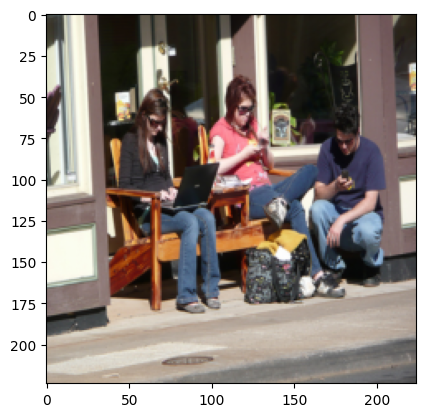

In [ ]:
img, cap = flickr8k_whole[32]
plt.imshow(img.transpose(1, 0).transpose(1, 2))
print("\n".join(cap))

# Show, Attend and Tell

Init of the LSTM states:
$$
c_0 = MLP_{init,c}(\sum_{i=1}^La_i)
$$
$$
h_0 = MLP_{init,h}(\sum_{i=1}^La_i)
$$


In [8]:
class SimpleMLP(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.5):
        super(SimpleMLP, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.Tanh(),
            nn.Dropout(p=0.5)
        )

    def forward(self, x):
        return self.mlp(x)

$$
e_{ti} =f_{att}(a_i, h_{t−1}) = v \cdot tanh(Wa_i + Uh_j )
$$

$$
α_{t} = SoftMax(e_t)
$$

Where $f_{att}$ is an MLP conditioned on $h_{t-1}$

In [9]:
"""
Input:
  - feature maps produced by the encoder e.g. VGG
  - hidden state from the LSTM
Output:
  - weights - the attention we should give each feature
"""
class Attention(nn.Module):
    def __init__(self, feature_dim=512, lstm_dim=512, out_dim=512):
        super(Attention, self).__init__()

        self.v = nn.Linear(out_dim, 1)
        self.W = nn.Linear(feature_dim, out_dim)
        self.U = nn.Linear(lstm_dim, out_dim)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    """
    Input:
        features: B x feat_num x feat_dim
        hidden_state: B x lstm_dim
    Output:
        alphas: B x feat_num x 1 (alpha_value)
    """
    def forward(self, features, hidden_states):
        assert features.dim() == 3, "Features have bad dimension number must be 3"
        assert hidden_states.dim() == 2, "Hidden states have bad dimension number must be 2"

        w_h = self.W(features)
        u_h = self.U(hidden_states)
        return self.softmax(self.v(self.tanh(w_h + u_h.unsqueeze(1))))

In [10]:
class ShowAttendAndTell(nn.Module):
    def __init__(self, vocab, vgg_type="vgg19", embedding_dim=300):
        super(ShowAttendAndTell, self).__init__()
        self.epochs_trained = 0

        self.lstm_dim = 1024
        self.index_to_word = list(vocab)
        self.word_to_index = {w:i for (i, w) in enumerate(self.index_to_word)}
        self.padding_index = self.word_to_index["<PAD>"]
        self.start_index   = self.word_to_index["<SOS>"]
        self.end_index     = self.word_to_index["<EOS>"]
        self.device = "cpu"

        self.feature_num = 14 * 14
        self.feature_dim = 512
        self.vocab_size = len(vocab)
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=self.padding_index)

        self.image_prepocess = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        all_models = {
            "vgg16": torchvision.models.vgg16,
            "vgg19": torchvision.models.vgg19,
        }
        vgg = all_models[vgg_type](weights='DEFAULT')

        self.extract_features = vgg.features
        if vgg_type == "vgg19":
            # Remove last layer (pooling)
            self.extract_features.pop(-1)

        for param in self.extract_features.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(input_size=self.feature_dim + self.embedding_dim, hidden_size=self.lstm_dim, num_layers=1)

        self.attention = Attention(self.feature_dim, self.lstm_dim)

        self.project_to_vocab = nn.Linear(self.lstm_dim, self.vocab_size)

        self.h_init = SimpleMLP(self.feature_dim, self.lstm_dim)
        self.c_init = SimpleMLP(self.feature_dim, self.lstm_dim)

        self.linear_beta = nn.Linear(self.lstm_dim, self.feature_dim)

    """
    Extract features from the CNN part of the vgg network
    Input:
        x: (3 x encoder_dim_h x encoder_dim_w) or (B x 3 x encoder_dim_h x encoder_dim_w)
    Output:
        annotation vectors: (B x feature_num x feature_dim)
    """
    def annotation_vectors(self, x):
        dims = x.dim()
        assert dims == 3 or dims == 4, "Features have bad dimension number, either 3 or 4 with batching"

        x = self.image_prepocess(x)
        x = self.extract_features(x)
        if dims == 3:
            return x.flatten(1).T[None]
        return x.flatten(2).transpose(2, 1)


    """
    The initial state for the LSTM is predicted by two MLP's
    that are fed with the averaged feature maps
    Input:
        features: (feature_num x feature_dim) or (B x feature_num x feature_dim)
    Output:
        h, c: (B x lstm_dim)
    """
    def initialize_states(self, features):
        dims = features.dim()
        assert dims == 2 or dims == 3, "Features have bad dimension number, either 2 or 3 with batching"

        if dims == 3:
            avg = features.mean(dim=1)
            return self.h_init(avg), self.c_init(avg)

        avg = features.mean(dim=0)
        return self.h_init(avg)[None], self.c_init(avg)[None]

    """
    Perform one step of the LSTM with a batch of words (as indices)
    and hidden states
    Input:
        x       - B x feature_num (196) x feature_dim (512)
        words   - B
        h_state - 1 x B x lstm_dim
    Output:
        projection - B x vocab_size
        h_state - 1 x B x lstm_dim
        alphas  - B x feature_num
    """
    def forward_word_batch(self, x, words, h_state, c_state):
        batch_size = words.shape[0]
        embeddnigs = self.embedding(words)  # B x embedding_dim
        alphas = self.attention(x, h_state) # B x feature_num

        context = (alphas * x).sum(dim=1)   # B x feature_dim

        beta = torch.sigmoid(self.linear_beta(h_state))
        beta_context = beta * context

        input = torch.cat((beta_context, embeddnigs), dim=1) # B x feature_dim + embedding_dim

        o_vec, (h_state, c_state) = self.lstm(input[None], (h_state[None], c_state[None]))
        projection = self.project_to_vocab(o_vec.squeeze(0))

        # We don't need the sequence dimension (only for LSTM)
        h_state, c_state = h_state.squeeze(0), c_state.squeeze(0)
        return projection, h_state, c_state, alphas.squeeze(2)



    def caption(self, x, word_limit=30, k=5):
        with torch.no_grad():
            x = x.to(self.device)
            x = self.annotation_vectors(x)
            h_state, c_state = self.initialize_states(x)
            acc_alphas = []

            # Do the first step
            projection, h_state, c_state, alphas = self.forward_word_batch(x, torch.tensor([self.start_index]).to(self.device), h_state, c_state)
            starting_values = torch.nn.functional.softmax(projection, dim=1).topk(k=k, dim=1)
            acc_alphas.append(alphas)
            # Prepare data for next steps
            # For batch calculations
            x = x.repeat(k, 1, 1)
            h_state = h_state.repeat(k, 1)
            c_state = c_state.repeat(k, 1)
            # Log prbability of the starting words
            prob_arr = torch.log(starting_values.values.clone().detach()).T # k x 1
            # Array of starting sequence indices
            sequences = starting_values.indices.clone().detach().T # k x 1
            seq_len   = torch.zeros((k, 1)).to(self.device) # k x 1
            for i in range(word_limit):
                words = sequences[:, i]
                # Create an array of indices of words that are <EOS>
                eos_words = torch.tensor(np.array([k for k, j in enumerate(words) if j.item() == self.end_index])).long()
                seq_len += 1
                seq_len[eos_words] -= 1
                if eos_words.numel() == k: break

                # Predict next words
                projection, h_state, c_state, alphas = self.forward_word_batch(x, words, h_state, c_state)
                probs = torch.nn.functional.softmax(projection, dim=1) # B x vocab_size
                # Select top k from the beams
                top = probs.topk(k=k, dim=1)
                top_vals = top.values.clone().detach()
                # Set prob to 1 to not change the probability of eos sequence
                # Set the rest to zero to not repeatedly choose the same sequence
                top_vals[eos_words, 0] = 1
                top_vals[eos_words, 1:] = 0
                # Calculate sequence prob matrix
                unregularized = (torch.log(top_vals) + prob_arr)
                prob_mat = unregularized / seq_len
                # From the prob_mat select k best ones
                p, ind = prob_mat.flatten().topk(k=k)
                prob_arr = unregularized.flatten()[ind].unsqueeze(1)
                # Calculate the positions of the best indices from top
                best_ind = np.array(np.unravel_index(ind.cpu().numpy(), prob_mat.shape))

                # The beams from which the words came
                best_beams = best_ind[0]
                # Choose the aproprieate beams, and hidden states, alphas
                sequences = sequences[best_beams]
                h_state   = h_state[best_beams]
                c_state   = c_state[best_beams]
                alphas    = alphas[best_beams]
                seq_len   = seq_len[best_beams]
                acc_alphas.append(alphas)
                new_words_ind = top.indices[best_ind]

                # Add the new words to the sequences
                sequences = torch.cat((sequences, new_words_ind.unsqueeze(1)), dim=1)

            return sequences, prob_arr, acc_alphas


    def decode_word_sequence(self, sequence):
        words = []
        for i in sequence:
            if i == self.end_index: break
            words.append(self.index_to_word[i])
        return " ".join(words)


    """
    Preproces a batch of sentences
    Tokenize and convert to indices
    """
    def sentence_preproces(self, sentences):
        result = []
        longest_sentence = 0
        for sentence in sentences:
            sentence = sentence.lower()
            for c in ".,;\":0123456789":
                sentence = sentence.replace(c, " " + c + " ")
            sentence = ["<SOS>"] + sentence.split() + ["<EOS>"]
            sentence = list(map(lambda x: self.word_to_index[x] , sentence))
            if len(sentence) > longest_sentence:
                longest_sentence = len(sentence)
            result.append(sentence)
        for i in range(len(result)):
            result[i] = result[i] + ([self.padding_index] * (longest_sentence - len(result[i])))
        return torch.tensor(np.array(result))

    def create_savepoint(self, epoch, desc, dataset="flickr8k"):
        torch.save(model.state_dict(), f"{desc}_SAT_epoch{epoch}_{dataset}_{self.feature_dim + self.embedding_dim}x{self.lstm_dim}.pt")

    """
        Input:
            x: B x C x H x W
            caps: B x L
    """
    def loss(self, x, caps, reg=0.1):
        x = x.to(self.device)
        caps = caps.to(self.device)

        x = self.annotation_vectors(x)
        h, c = self.initialize_states(x)

        acc_logits = torch.zeros(caps.shape[1], caps.shape[0], self.vocab_size)

        alphas_history = []

        for words, t in zip(caps.T, range(caps.shape[1])):
            embedding = self.embedding(words)
            at = self.attention(x, h)
            context = (at * x).sum(dim=1)

            beta = torch.sigmoid(self.linear_beta(h))
            beta_context = beta * context

            i = torch.cat((beta_context, embedding), dim=1)
            prob_vec, (h, c) = self.lstm(i[None], (h[None], c[None]))
            prob_vec = prob_vec.squeeze(0)
            h, c = h.squeeze(0), c.squeeze(0)

            acc_logits[t, :] = self.project_to_vocab(prob_vec)

            alphas_history.append(at[None])

            acc_logits[t, :] = self.project_to_vocab(prob_vec)

        alphas_history = torch.cat(alphas_history) # C x B x L x 1
        alphas_history = alphas_history.squeeze(3) # C x B x L

        regularization = reg * ((1 - alphas_history.sum(0))**2).mean()

        return nn.functional.cross_entropy(acc_logits[:-1].transpose(0, 1).transpose(1, 2), caps[:,1:].type(torch.LongTensor), ignore_index=self.padding_index) + regularization


    def train_model(self, dataloader, epochs=3, batch_size=64):
        dataset_size = len(dataloader)

        print(f"Current epoch: {self.epochs_trained}")
        print(f"Batch size x batches: {batch_size} * {dataset_size}")
        print(f"Epochs: {epochs}")

        parameters = list(p for name, p in model.named_parameters() if "extract_features" not in name)
        optimizer = optim.Adam(parameters, lr=0.001)
        t_total = time()
        for epoch in range(epochs):

            e_time = 0
            t_epoch = time()
            for (img_batch, txt_batch), i in zip(dataloader, range(1, dataset_size+1)):
                t_batch = time()
                for txts in txt_batch:
                    optimizer.zero_grad()
                    loss = self.loss(img_batch, self.sentence_preproces(txts))
                    loss.backward()
                    optimizer.step()

                e_time += (time() - t_batch)
                print(f"\rLoss: {loss.item()} time per batch: {(e_time / i):.2f}s expected epoch time: {((e_time / i * (dataset_size - i)) / 60):.2f}min", end="")

            self.epochs_trained += 1
            self.create_savepoint(self.epochs_trained, "reg")

            print(f"\rEpoch {epoch+1} time: {(time() - t_epoch):.2f}s")
        print(f"Total time: {(time() - t_total)/60:.2f}min")


    def to(self, device="cpu"):
        super(ShowAttendAndTell, self).to(device)
        self.device = device
        return self

model = ShowAttendAndTell(vocab=vocab)
model = model.to("cuda")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.9MB/s]


# Load a model

In [11]:
![ -d trained_models ] || gdown --folder 'https://drive.google.com/drive/folders/1w4obEyGMoNUO38Q24v1I1d7sADHUuuS2?usp=drive_link' -O trained_models

Retrieving folder list
Processing file 1xSHg23YyHRyfS4vgmmsEjCA69bgZLMgS reg_SAT_epoch1_flickr8k_812x1024.pt
Processing file 14JSM5Z2nN4i7JniZy6WQlZk4EQnBZT1k reg_SAT_epoch2_flickr8k_812x1024.pt
Processing file 1VwnWRVWD0Ol4sFRoo-VWiZiCjfBuhiz7 reg_SAT_epoch3_flickr8k_812x1024.pt
Processing file 16pMO1aS4kAXvOo4HC-ztCO3W7ikXpkEo reg_SAT_epoch4_flickr8k_812x1024.pt
Processing file 1GdB6cdrgS9QoRbm-MWiU0GbRlmJYI-SC reg_SAT_epoch5_flickr8k_812x1024.pt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1xSHg23YyHRyfS4vgmmsEjCA69bgZLMgS
To: /content/trained_models/reg_SAT_epoch1_flickr8k_812x1024.pt
100% 455M/455M [00:04<00:00, 92.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=14JSM5Z2nN4i7JniZy6WQlZk4EQnBZT1k
To: /content/trained_models/reg_SAT_epoch2_flickr8k_812x1024.pt
100% 455M/455M [00:07<00:00, 59.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VwnWRVWD0Ol4sFR

Load the trained model:

In [12]:
model.load_state_dict(torch.load("trained_models/reg_SAT_epoch4_flickr8k_812x1024.pt", map_location=torch.device('cuda')))

<All keys matched successfully>

# Test the model

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_dataset)

In [ ]:
def calculate_bleu(model, dataloader, n=1):
    model.eval()
    model.to("cuda")

    data_size = len(dataloader)
    references  = []
    predictions = []

    for i, (img, caps) in enumerate(tqdm(dataloader)):
        t1 = time()
        references.append([cap[0].lower().split() for cap in caps])
        seq, __, _ = model.caption(img, word_limit=30, k=3)
        predictions.append(model.decode_word_sequence(seq[0]).split())
    print()
    return bleu_score(predictions, references, max_n=n, weights=[1/n for _ in range(n)])

# Create visualizations

In [20]:
def alpha_image(img, model, width=4, k=3, smooth=True):
    model.eval()
    seq, prob, alp = model.caption(img, k=k)
    img = np.clip(img.cpu().numpy().transpose(1, 2, 0), 0, 1)

    words = model.decode_word_sequence(seq[0]).split()
    height = len(words) // width
    if (len(words) % width) != 0: height += 1

    fig, axs = plt.subplots(height, width, figsize=(2.5*width, 2*height))

    for i, word in enumerate(words):
        x, y = i % width, i // width
        alpha = np.clip(alp[i][0].cpu().numpy(), 0, 1)

        if smooth:
            alpha_img = skimage.transform.pyramid_expand(alpha.reshape(14, 14), upscale=16, sigma=20)
        else:
            alpha_img = skimage.transform.resize(alpha.reshape(14, 14), [224, 224])

        ax = axs[y, x]
        ax.imshow(img)
        ax.imshow(alpha_img, alpha=0.8, cmap="Greys_r")
        ax.set_title(word)
        ax.axis('off')

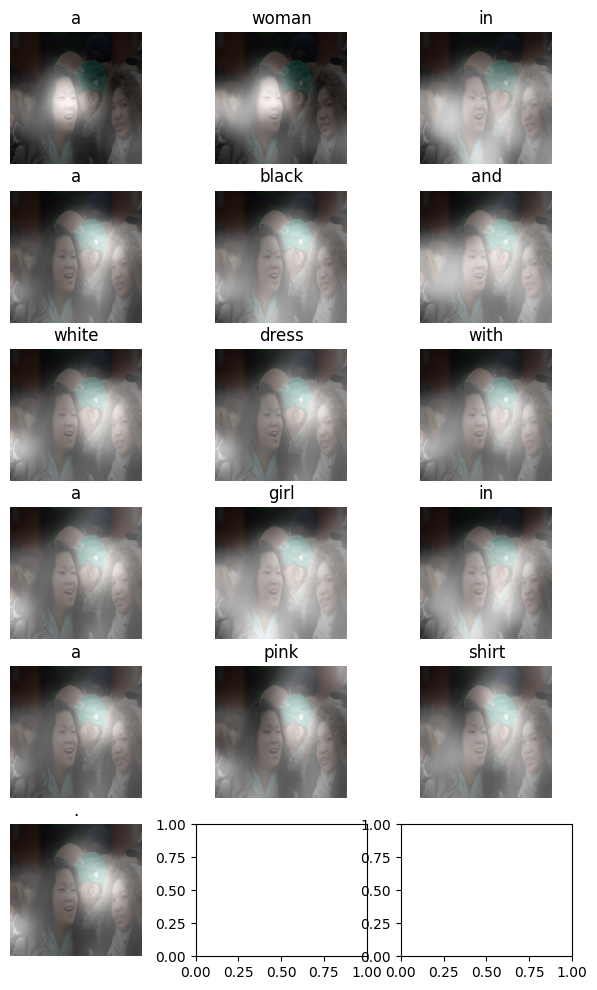

In [ ]:
alpha_image(test_dataset[6][0], model, width=3)

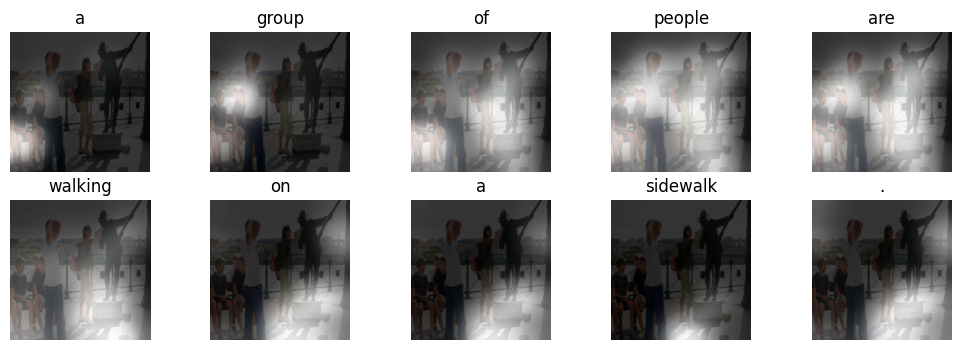

In [ ]:
alpha_image(test_dataset[10][0], model, width=5)

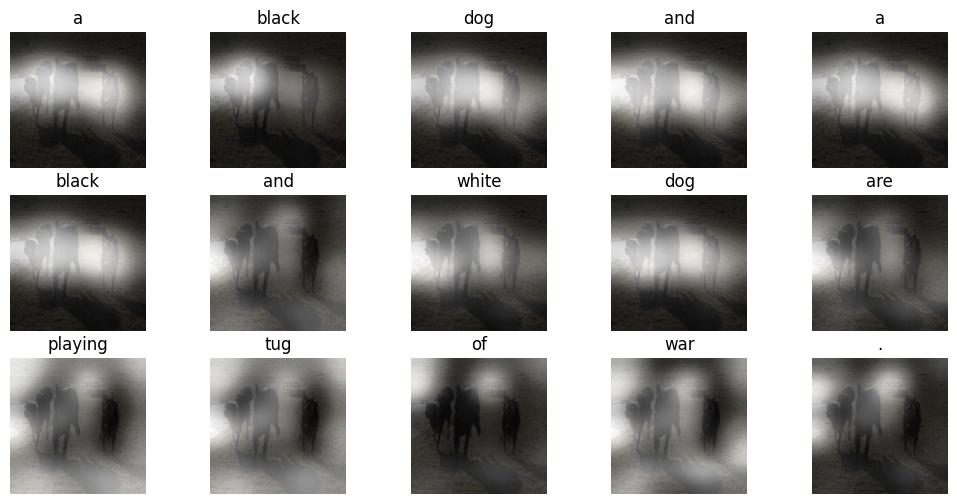

In [ ]:
alpha_image(test_dataset[100][0], model, smooth=True, width=5)

In [19]:
def image_with_captions(datapoint, model, k=5, smooth=True, logprob=False):
    model.eval()
    img, target = datapoint
    seq, probs, alp = model.caption(img, k=k)

    img = np.clip(img.cpu().numpy().transpose(1, 2, 0), 0, 1)
    target_str = "\n".join(target)
    if logprob:
        preds_str  = "\n".join([f"{model.decode_word_sequence(s)} {p.item()}" for s, p in list(zip(seq, probs))[:5]])
    else:
        preds_str  = "\n".join([model.decode_word_sequence(s) for s in seq[:5]])
    print("Ground truths: ")
    print(target_str)
    print()
    print("Predictions: ")
    print(preds_str)
    print()
    plt.imshow(img)
    plt.axis('off')

Ground truths: 
A man is wearing a Sooners red football shirt and helmet .
A Oklahoma Sooners football player wearing his jersey number 28 .
A Sooners football player weas the number 28 and black armbands .
Guy in red and white football uniform
The American footballer is wearing a red and white strip .

Predictions: 
a football player # 2 5 .
a football player is wearing a red and white uniform .
a football player in a red and white uniform .
a football player wearing a red and white uniform .
a football player is wearing a red and white helmet .



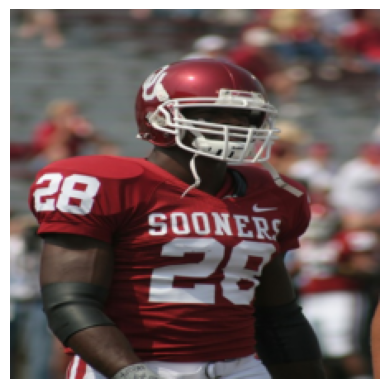

In [ ]:
image_with_captions(test_dataset[4], model, k=5)

In [ ]:
!gdown https://cdn.discordapp.com/attachments/1053643367180927106/1121002307623063582/iu.png -O giraffe.png

Downloading...
From: https://cdn.discordapp.com/attachments/1053643367180927106/1121002307623063582/iu.png
To: /content/giraffe.png
100% 2.68M/2.68M [00:00<00:00, 193MB/s]


In [18]:
def prepare_custom_datapoint(path, target=[]):
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224), antialias=True)])
    img = Image.open(path).convert("RGB")
    img = transform(img)
    if img.shape[0] == 4:
        img = img[:-1]

    return img, target

In [ ]:
giraffe_data = prepare_custom_datapoint("giraffe.png", ["A giraffe is looking into the camera ."])

Ground truths: 
A giraffe is looking into the camera .

Predictions: 
a dog is running through the water .
a dog is running through the snow .
a dog is running out of a pool .
a dog is running out of a blue and yellow tube .
a dog is running out of a blue and yellow tunnel .



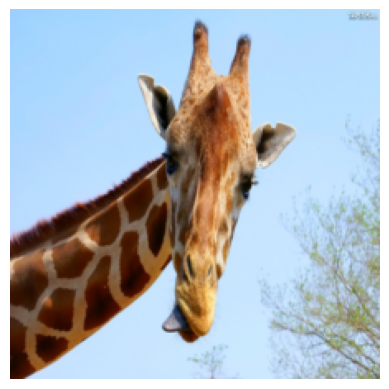

In [ ]:
image_with_captions(giraffe_data, model, k=5)

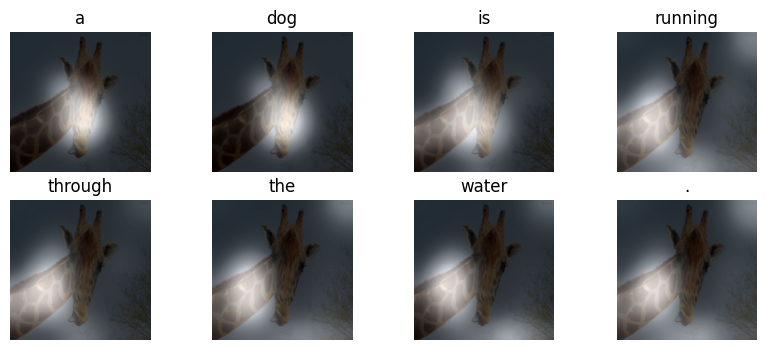

In [ ]:
alpha_image(giraffe_data[0], model, smooth=True, width=4)